In [1]:
import h5py
import hdf5plugin
import numpy as np
import pandas as pd
import os,sys,glob
import copy
import time
import xarray as xr
import pickle

import trajectory as trj
# import rs_drift.drift as trj

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})

from eccodes import *
from functools import partial
from collections import OrderedDict


sys.path.insert(0, "/users/staff/uvoggenberger/uvpy/rasotools-master/")
import rasotools

plt.rcParams['lines.linewidth'] = 3

import warnings
warnings.filterwarnings('ignore')

import ray
# ray.init(num_cpus=80)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def datetime_to_seconds(dates, ref='1900-01-01T00:00:00'):
    """ from datetime64 to seconds since 1900-01-01 00:00:00"""
    return ((dates - np.datetime64(ref)) / np.timedelta64(1, 's')).astype(np.int64)

def seconds_to_datetime(seconds, ref='1900-01-01'):
    """ from seconds to datetime64 """
    seconds = np.asarray(seconds)
    return pd.to_datetime(seconds, unit='s', origin=ref)

2024-03-14 11:39:48,540	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
sys.path.append(os.getcwd() + "/../cds-backend/code/")
import cds_eua4 as eua

no config found


/mnt/users/scratch/leo/scratch/converted_v17/long/0-20000-0-33791_CEUAS_merged_v3.nc
48.03329849243164 33.21670150756836


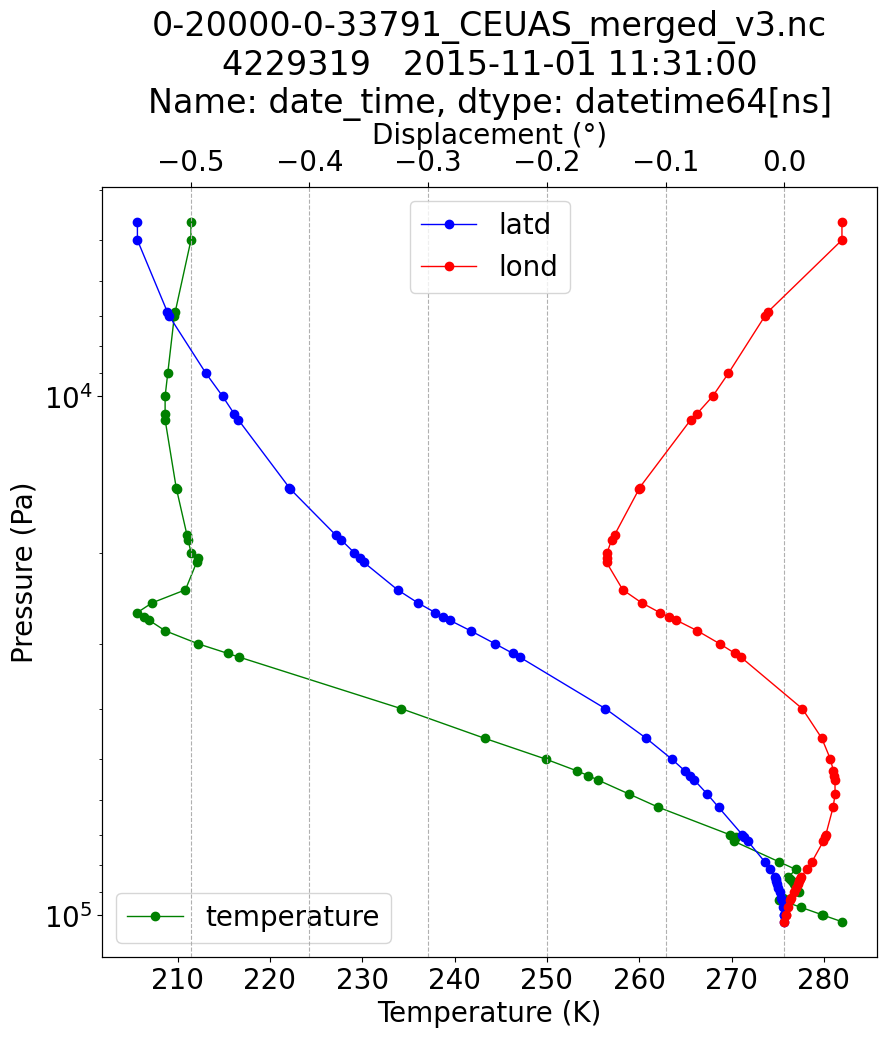

In [96]:
files = glob.glob("/mnt/users/scratch/leo/scratch/converted_v17/long/*33791*.nc")[:1]
for file_i in files:
    with eua.CDMDataset(file_i
    ) as file:
        df = file.to_dataframe(
            groups=["observations_table"],
            variables=["date_time", "observed_variable", "observation_value", "z_coordinate", "latd", "lond", "timed", "latitude", "longitude"],
        )
    df = df[df.observed_variable == 126]
    df.sort_values('z_coordinate', inplace=True)
    df = df[np.logical_and(df.date_time >= '201511010000', df.date_time < '201511011500')]

    print(file_i)
    print(df.latitude.iloc[-1], df.longitude.iloc[-1])
    fig, ax1 = plt.subplots(figsize=(10, 10))

    ax1.plot(df.observation_value, df.z_coordinate, linestyle='-', marker='o', linewidth = 1, label='temperature', color='green')
    ax1.invert_yaxis()
    ax1.legend(loc='lower left')
    ax1.set_yscale('log')
    ax1.set_xlabel('Temperature (K)')
    ax1.set_ylabel('Pressure (Pa)')

    ax2 = ax1.twiny()
    ax2.set_xlabel('Displacement (°)')
    ax2.plot(df.latd, df.z_coordinate, linestyle='-', marker='o', linewidth = 1, label = 'latd', color='blue')
    ax2.plot(df.lond, df.z_coordinate, linestyle='-', marker='o', linewidth = 1, label = 'lond', color='red')
    ax2.legend(loc='upper center')
    
    plt.title(file_i.split('/')[-1] + '\n' + str(df.date_time.drop_duplicates()))
    plt.grid(True, which="both", ls="--")
    plt.show()
    plt.close()


/mnt/users/scratch/leo/scratch/converted_v17/long/0-20000-0-40848_CEUAS_merged_v3.nc


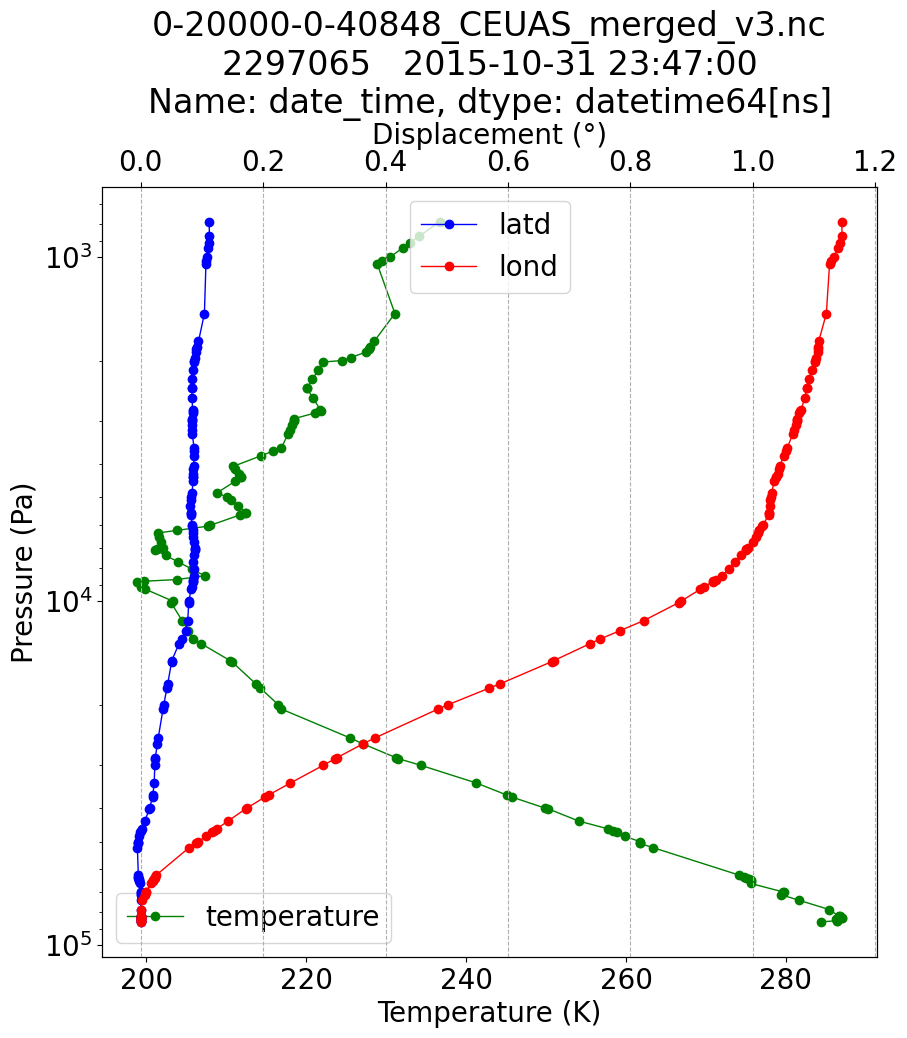

In [95]:
files = glob.glob("/mnt/users/scratch/leo/scratch/converted_v17/long/*40848*.nc")[:1]
for file_i in files:
    with eua.CDMDataset(file_i
    ) as file:
        df = file.to_dataframe(
            groups=["observations_table"],
            variables=["date_time", "observed_variable", "observation_value", "z_coordinate", "latd", "lond", "timed", "latitude", "longitude"],
        )
    df = df[df.observed_variable == 126]
    df.sort_values('z_coordinate', inplace=True)
    df = df[np.logical_and(df.date_time >= '201510312200', df.date_time < '201511010200')]

    print(file_i)
    fig, ax1 = plt.subplots(figsize=(10, 10))

    ax1.plot(df.observation_value, df.z_coordinate, linestyle='-', marker='o', linewidth = 1, label='temperature', color='green')
    ax1.invert_yaxis()
    ax1.legend(loc='lower left')
    ax1.set_yscale('log')
    ax1.set_xlabel('Temperature (K)')
    ax1.set_ylabel('Pressure (Pa)')

    ax2 = ax1.twiny()
    ax2.set_xlabel('Displacement (°)')
    ax2.plot(df.latd, df.z_coordinate, linestyle='-', marker='o', linewidth = 1, label = 'latd', color='blue')
    ax2.plot(df.lond, df.z_coordinate, linestyle='-', marker='o', linewidth = 1, label = 'lond', color='red')
    ax2.legend(loc='upper center')
    
    plt.title(file_i.split('/')[-1] + '\n' + str(df.date_time.drop_duplicates()))
    plt.grid(True, which="both", ls="--")
    plt.show()
    plt.close()


In [109]:
def calc_p_from_h(h):
    a = 5.252368255329
    b = 44330.769230769
    c = 0.000157583169442
    ptro = 226.547172
    po = 1013.25
    
    p_out = []
    for hi in h:
        if (hi > 11000):
            y = -c * (hi - 11000)
            p = ptro * np.exp(y)

        else:
            y = 1 - hi / b
            p = po * (y**a)
        p_out.append(p)
    return p_out


In [102]:
varsel_era = str(129)
files = glob.glob('/mnt/scratch/scratch/leo/scratch/era5/gridded/era5fct.' + str(year) + str(mon).zfill(2) + '*.' + varsel_era + '.nc')[0]
ds_fc = xr.load_dataset(files)

ds_fc_time = ds_fc.sel(time=pd.to_datetime(201511011200), method='nearest')
station_data = ds_fc_time.interp(latitude=[48.03329849243164], longitude=[33.21670150756836], method="linear")
print(station_data)



<xarray.Dataset>
Dimensions:    (level: 16, latitude: 1, longitude: 1)
Coordinates:
  * level      (level) int32 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
    time       datetime64[ns] 2015-11-01T09:00:00
  * latitude   (latitude) float64 48.03
  * longitude  (longitude) float64 33.22
Data variables:
    z          (latitude, longitude, level) float64 2.985e+05 ... 3.314e+03


In [111]:
station_data.z

<xarray.DataArray 'z' (latitude: 1, longitude: 1, level: 16)>
array([[[298519.69859385, 255738.23017955, 231376.03209359,
         200849.46424123, 180679.16602236, 159139.93525282,
         134489.81395408, 117269.43705379, 103706.03058572,
          92102.84653611,  72758.19512024,  56812.75365009,
          31479.46875752,  16215.90943204,   9493.79481291,
           3314.07134507]]])
Coordinates:
  * level      (level) int32 10 20 30 50 70 100 150 ... 400 500 700 850 925 1000
    time       datetime64[ns] 2015-11-01T09:00:00
  * latitude   (latitude) float64 48.03
  * longitude  (longitude) float64 33.22
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [113]:
calc_p_from_h(station_data.z.values[0,0]/9.81)

[10.602499121785911,
 21.079708173423942,
 31.17615784273095,
 50.90788805743299,
 70.38808141031255,
 99.48629529000578,
 147.8188757031058,
 194.92359228715284,
 242.27012212424356,
 290.3029425759229,
 387.32981196812483,
 485.70708829326395,
 682.838853139384,
 829.9156763450836,
 902.3350027208375,
 973.3453226512358]